# Choosing the best Algorithm by comparing its accuracy over all 80 Zika datasets

### Create one folder with all 80 bam files

In [1]:
cd /mnt

In [3]:
# mkdir Zika_total

In [4]:
ls

Zika_dedup       Zika_round4               Zika_total
Zika_round3_exp  Zika_subgenomic_plotting  Zika_virus_expression


In [6]:
cat Zika_subgenomic_plotting/acc.txt Zika_round3_exp/combined_acc.txt Zika_round4/Homo_sapiens_paired.txt > Zika_total/acc.txt

In [8]:
cp Zika_virus_expression/*.bam Zika_total/
cp Zika_virus_expression/*.bai Zika_total/

In [9]:
cp Zika_round3_exp/*.bam Zika_total/
cp Zika_round3_exp/*.bai Zika_total/

In [10]:
cp Zika_round4/*.bam Zika_total/
cp Zika_round4/*.bai Zika_total/

In [ ]:
mkdir /mnt/Zika_total/plotting

In [ ]:
cd /mnt/Zika_round3_exp/plotting
cp -r * /mnt/Zika_total/plotting/

In [ ]:
cp negative_depth/* /mnt/Zika_total/plotting/negative_depth/
cp negative_end/* /mnt/Zika_total/plotting/negative_end/
cp negative_start/* /mnt/Zika_total/plotting/negative_start/
cp original_depth/* /mnt/Zika_total/plotting/original_depth/
cp positive_depth/* /mnt/Zika_total/plotting/positive_depth/
cp positive_end/* /mnt/Zika_total/plotting/positive_end/
cp positive_start/* /mnt/Zika_total/plotting/positive_start/

In [ ]:
while read p; do
if [ -f /mnt/Zika_total/plotting/negative_depth/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/negative_end/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/negative_start/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/original_depth/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/positive_depth/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/positive_end/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

if [ -f /mnt/Zika_total/plotting/positive_start/$p".tsv" ]; then
    echo $p" exists"
else
    echo 'File does not exist.'
fi

done < acc.txt


# 1. Final Plots Sliding Window Algo 30 nt + Top 3 Peak Detection + 100 nt around peaks

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import ruptures as rpt
import pickle

In [3]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_total/acc.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)
print(acc_list)

['ERR1802071', 'ERR1802073', 'ERR1802074', 'ERR1802079', 'SRR12615449', 'SRR12615452', 'SRR12615453', 'SRR12615466', 'SRR12615469', 'SRR12615470', 'SRR13084686', 'SRR13084689', 'SRR13084692', 'SRR13084695', 'SRR15923994', 'SRR15923995', 'SRR15923996', 'SRR21109253', 'SRR21109254', 'SRR21109257', 'SRR7660688', 'SRR7660689', 'SRR7660692', 'SRR7660693', 'SRR7660696', 'SRR7660698', 'SRR7660703', 'SRR7660704', 'SRR7660705', 'SRR7660718', 'SRR7660719', 'SRR7660720', 'SRR7660721', 'SRR7660722', 'SRR7660723', 'SRR7660724', 'SRR7660725', 'SRR7660726', 'SRR7660739', 'SRR7660740', 'SRR7660741', 'SRR7660742', 'SRR7660743', 'SRR7660744', 'SRR7660745', 'SRR7660746', 'SRR7660747', 'SRR8155998', 'SRR8155999', 'SRR8156000', 'SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146', 'SR

In [25]:
%cd /mnt/Zika_total/plotting/

/mnt/Zika_total/plotting


In [4]:
reference_virus = {
"ERR1802071": "Zika_brazil","ERR1802073": "Zika_brazil","ERR1802074": "Zika_brazil","ERR1802079": "Zika_brazil","SRR12615449": "Zika_brazil","SRR12615452": "Zika_brazil","SRR12615453": "Zika_brazil","SRR12615466": "Zika_brazil","SRR12615469": "Zika_brazil","SRR12615470": "Zika_brazil","SRR13084686": "Zika_brazil","SRR13084689": "Zika_brazil","SRR13084692": "Zika_brazil","SRR13084695": "Zika_brazil","SRR21109253": "Zika_brazil","SRR21109254": "Zika_brazil","SRR21109257": "Zika_brazil","SRR7660688": "Zika_brazil","SRR7660689": "Zika_brazil","SRR7660692": "Zika_brazil","SRR7660693": "Zika_brazil","SRR7660696": "Zika_brazil","SRR7660698": "Zika_brazil","SRR7660703": "Zika_brazil","SRR7660704": "Zika_brazil","SRR7660705": "Zika_brazil","SRR7660718": "Zika_brazil","SRR7660719": "Zika_brazil","SRR7660720": "Zika_brazil","SRR7660721": "Zika_brazil","SRR7660722": "Zika_brazil","SRR7660723": "Zika_brazil","SRR7660724": "Zika_brazil","SRR7660725": "Zika_brazil","SRR7660726": "Zika_brazil","SRR7660739": "Zika_brazil","SRR7660740": "Zika_brazil","SRR7660741": "Zika_brazil","SRR7660742": "Zika_brazil","SRR7660743": "Zika_brazil","SRR7660744": "Zika_brazil","SRR7660745": "Zika_brazil","SRR7660746": "Zika_brazil","SRR7660747": "Zika_brazil","SRR8155998": "Zika_brazil","SRR8156000": "Zika_brazil","SRR9106108": "Zika_brazil","SRR9106110": "Zika_brazil","SRR9106112": "Zika_brazil","SRR9106114": "Zika_brazil","SRR9106116": "Zika_brazil","SRR9106118": "Zika_brazil","SRR9106120": "Zika_brazil","SRR9106122": "Zika_brazil","SRR9106124": "Zika_brazil","SRR9106126": "Zika_brazil","SRR9106128": "Zika_brazil","SRR9106130": "Zika_brazil","SRR9106132": "Zika_brazil","SRR9106134": "Zika_brazil","SRR9106136": "Zika_brazil","SRR9106138": "Zika_brazil","SRR9106140": "Zika_brazil","SRR9106142": "Zika_brazil","SRR9106144": "Zika_brazil","SRR9106146": "Zika_brazil","SRR9610797": "Zika_brazil","SRR9610798": "Zika_brazil","SRR9610799": "Zika_brazil","SRR9610800": "Zika_brazil","SRR9610801": "Zika_brazil","SRR9610805": "Zika_brazil","SRR9971529": "Zika_brazil","SRR9971530": "Zika_brazil","SRR9971531": "Zika_brazil","SRR9971532": "Zika_brazil","SRR9971533": "Zika_brazil","SRR9971534": "Zika_brazil","SRR9971535": "Zika_brazil","SRR9971536": "Zika_brazil","SRR9971537": "Zika_brazil","SRR9971538": "Zika_brazil","SRR9971539": "Zika_brazil","SRR9971540": "Zika_brazil","SRR15923994": "Zika_uganda","SRR15923995": "Zika_uganda","SRR15923996": "Zika_uganda","SRR8155999": "Zika_uganda"
}

In [8]:
for acc in acc_list:
    
    original_depth = pd.read_csv("original_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    negative_depth = pd.read_csv("negative_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_start = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_start = pd.read_csv("negative_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_end = pd.read_csv("positive_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_end = pd.read_csv("negative_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])

    #5' start peak detection
    positive_start2 = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_start2 = positive_start2.sort_values(by=['Count'],ascending=False)
    top3peaks = positive_start2.head(3)
    top3peaks = top3peaks.to_numpy()


    #Read coverage Change Point Detection
    depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    depth = depth.drop(columns=["Virus"])
    depth.set_index("Position", inplace=True)

    coverage = depth['Count'].values.reshape(-1,1)
    algo = rpt.Window(model="l2",width=30)
    algo.fit(coverage)
    result = algo.predict(n_bkps=1)
    
    
    # Create a list of the dataframes for easy iteration
    dataframes = [original_depth, positive_depth, negative_depth, positive_start, negative_start, positive_end, negative_end]
    titles = [reference_virus[acc] + " Coverage", acc + " Sense Reads Coverage",acc + " Antisense Reads Coverage",
              acc + " Sense Read 5\' End",acc + " Antisense Read 3\' End", acc + " Sense Read 3\' End", acc + " Antisense Read 5\' End"]
    colours = ["magma",None, "autumn",None,"autumn",None, "autumn"]
    
    
    
    # Create subplots: 4 rows and 2 columns, but only using the first slot for a single graph
    fig = plt.figure()
    axs = []
    gs = gridspec.GridSpec(4, 2)
    axs.append(plt.subplot(gs[0, 0]))
    axs.append(plt.subplot(gs[1, 0]))
    axs.append(plt.subplot(gs[1, 1]))
    axs.append(plt.subplot(gs[2, 0]))
    axs.append(plt.subplot(gs[2, 1]))
    axs.append(plt.subplot(gs[3, 0]))
    axs.append(plt.subplot(gs[3, 1]))
    axs.append(plt.subplot(gs[0, 1]))
    
    # Plot each DataFrame on its corresponding subplot
    for i, df in enumerate(dataframes):
        ax = axs[i]
        if i==3:
            ax.plot(top3peaks[0][0],top3peaks[0][1], "ob")
            ax.plot(top3peaks[1][0],top3peaks[1][1], "ob")
            ax.plot(top3peaks[2][0],top3peaks[2][1], "ob")
            ax.legend(['Peaks'])
        if i==1:
            ax.vlines(result[0],ymin=0,ymax=df['Count'].max(), color='black', linestyles='dashed', linewidth = 4)

        if i==0 or i==1 or i==2:
            # predicted 5′ end of RNA “stem-loop 2” (SL2)
            ax.vlines(10478,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)

            # predicted 5′ end of RNA “stem-loop 1” (SL1)
            ax.vlines(10394,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)
            

            #position from Andrew's paper: https://www.biorxiv.org/content/10.1101/112904v1.full
            
        df.plot("Position", "Count", ax=ax, colormap=colours[i], figsize=(18, 18))
        ax.set_title(titles[i])

    if (top3peaks[0][0] - 100) <= result[0] <= (top3peaks[0][0] + 100) or \
        (top3peaks[1][0] - 100) <= result[0] <= (top3peaks[1][0] + 100) or \
        (top3peaks[2][0] - 100) <= result[0] <= (top3peaks[2][0] + 100):
        result = "Prediction: True"
    else:
        result = "Prediction: False"
    
    axs[7].annotate(result, (0.22,0.45), fontsize=45, bbox=dict(boxstyle="round", fc="0.8"))
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # plt.show()
    fig.savefig('/mnt/Zika_total/1final_plots/' + acc + '.png')
    plt.close(fig)

# Testing all Algos

In [5]:
dir(rpt.costs)

['CostAR',
 'CostCLinear',
 'CostCosine',
 'CostL1',
 'CostL2',
 'CostLinear',
 'CostMl',
 'CostNormal',
 'CostRank',
 'CostRbf',
 'NotEnoughPoints',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'cost_factory',
 'costautoregressive',
 'costclinear',
 'costcosine',
 'costl1',
 'costl2',
 'costlinear',
 'costml',
 'costnormal',
 'costrank',
 'costrbf',
 'factory']

In [3]:
#5' start peak detection
def start(acc):
    positive_start2 = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_start2 = positive_start2.sort_values(by=['Count'],ascending=False)
    top3peaks = positive_start2.head(3)
    top3peaks = top3peaks.to_numpy()
    
    
    #Read coverage Change Point Detection
    depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    depth = depth.drop(columns=["Virus"])
    depth.set_index("Position", inplace=True)
    
    coverage = depth['Count'].values.reshape(-1,1)
    return coverage, top3peaks


# algo = rpt.Window(model="l2",width=30)

def end(algo, coverage, top3peaks):
    algo.fit(coverage)
    result = algo.predict(n_bkps=1)
    if (top3peaks[0][0] - 100) <= result[0] <= (top3peaks[0][0] + 100) or \
        (top3peaks[1][0] - 100) <= result[0] <= (top3peaks[1][0] + 100) or \
        (top3peaks[2][0] - 100) <= result[0] <= (top3peaks[2][0] + 100):
        verdict = True
    else:
        verdict = False
    return verdict

In [9]:
# Number of Breakpoints = 1
# I will try all algos with all cost functions
# Plot my metrics as seperates graphs for each and find the best overall winner. 
# Precision is important (but I expect a lot of False Positives in the tool, so not the best metric) : TP/(TP+FP)
# Recall is VERY IMPORTANT TP/(TP+FN). I would hypothetically want this to be a 100%. So whatever a human can pick out, the model should definitely pick out. 
# F1 score is 2(p*r)/(p+r), where r is the recall and p is precision

In [7]:
costs = ['ar','clinear','cosine','l1','l2','linear','mahalanobis','normal','rank','rbf']
# interesting that rank uses multi threading i think
# costs = ['l1','l2','linear','normal','rank'] are very fast, with rank being a bit slower but still very fast. All finished in under 20 minutes
# clinear is also very fast. only 2 minutes for 82 datasets. 

In [ ]:
binseg={}
bottomup={}
dynp={}
window30={}
window60={}
window100={}
window200={}
window1000={}
window5000={}

for model in costs:
    for acc in acc_list:
        coverage, top3peaks = start(acc)
        algo = rpt.Binseg(model=model)
        verdict = end(algo, coverage, top3peaks)
        binseg[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.BottomUp(model=model)
        verdict = end(algo, coverage, top3peaks)
        bottomup[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Dynp(model=model)
        verdict = end(algo, coverage, top3peaks)
        dynp[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=30)
        verdict = end(algo, coverage, top3peaks)
        window30[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=60)
        verdict = end(algo, coverage, top3peaks)
        window60[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=100)
        verdict = end(algo, coverage, top3peaks)
        window100[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=200)
        verdict = end(algo, coverage, top3peaks)
        window200[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=500)
        verdict = end(algo, coverage, top3peaks)
        window500[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=1000)
        verdict = end(algo, coverage, top3peaks)
        window1000[acc] = verdict

        coverage, top3peaks = start(acc)
        algo = rpt.Window(model=model,width=5000)
        verdict = end(algo, coverage, top3peaks)
        window5000[acc] = verdict


algorithms2 = [
    rpt.KernelCPD(kernel="linear", min_size=2),
    rpt.KernelCPD(kernel="rbf", min_size=2),
    rpt.KernelCPD(kernel="cosine", min_size=2),
    rpt.KernelCPD(kernel="linear", min_size=10),
    rpt.KernelCPD(kernel="rbf", min_size=10),
    rpt.KernelCPD(kernel="cosine", min_size=10),
    rpt.KernelCPD(kernel="linear", min_size=50),
    rpt.KernelCPD(kernel="rbf", min_size=50),
    rpt.KernelCPD(kernel="cosine", min_size=50),
    rpt.KernelCPD(kernel="linear", min_size=200),
    rpt.KernelCPD(kernel="rbf", min_size=200),
    rpt.KernelCPD(kernel="cosine", min_size=200),
    rpt.KernelCPD(kernel="linear", min_size=500),
    rpt.KernelCPD(kernel="rbf", min_size=500),
    rpt.KernelCPD(kernel="cosine", min_size=500)
]

KernelCPDlinear2 = {}
KernelCPDrbf2 = {}
KernelCPDcosine2 = {}
KernelCPDlinear10 = {}
KernelCPDrbf10 = {}
KernelCPDcosine10 = {}
KernelCPDlinear50 = {}
KernelCPDrbf50 = {}
KernelCPDcosine50 = {}
KernelCPDlinear200 = {}
KernelCPDrbf200 = {}
KernelCPDcosine200 = {}
KernelCPDlinear500 = {}
KernelCPDrbf500 = {}
KernelCPDcosine500 = {}

dictionaries = [KernelCPDlinear2,KernelCPDrbf2,KernelCPDcosine2,KernelCPDlinear10,KernelCPDrbf10,KernelCPDcosine10,KernelCPDlinear50,KernelCPDrbf50,KernelCPDcosine50,KernelCPDlinear200,KernelCPDrbf200,KernelCPDcosine200,KernelCPDlinear500,KernelCPDrbf500,KernelCPDcosine500]



for acc in acc_list:
    for i,algorithm in enumerate(algorithms2):
        coverage, top3peaks = start(acc)
        algo = algorithm
        verdict = end(algo, coverage, top3peaks)
        dictionaries[i][acc] = verdict

# Algorithm2 isnt bad either. It is going pretty fast with about 1 accession taking ~1 min, but hat 1 min is running all 15 algos

In [1]:
import pickle

with open('binseg.pkl', 'wb') as f:
	pickle.dump(binseg, f)
	
with open('bottomup.pkl', 'wb') as f:
	pickle.dump(bottomup, f)
	
with open('dynp.pkl', 'wb') as f:
	pickle.dump(dynp, f)
	
with open('window30.pkl', 'wb') as f:
	pickle.dump(window30, f)
	
with open('window60.pkl', 'wb') as f:
	pickle.dump(window60, f)
	
with open('window100.pkl', 'wb') as f:
	pickle.dump(window100, f)
	
with open('window200.pkl', 'wb') as f:
	pickle.dump(window200, f)
	
with open('window1000.pkl', 'wb') as f:
	pickle.dump(window1000, f)
	
with open('window5000.pkl', 'wb') as f:
	pickle.dump(window5000, f)
	
with open('KernelCPDlinear2.pkl', 'wb') as f:
	pickle.dump(KernelCPDlinear2, f)
	
with open('KernelCPDrbf2.pkl', 'wb') as f:
	pickle.dump(KernelCPDrbf2, f)
	
with open('KernelCPDcosine2.pkl', 'wb') as f:
	pickle.dump(KernelCPDcosine2, f)
	
with open('KernelCPDlinear10.pkl', 'wb') as f:
	pickle.dump(KernelCPDlinear10, f)
	
with open('KernelCPDrbf10.pkl', 'wb') as f:
	pickle.dump(KernelCPDrbf10, f)
	
with open('KernelCPDcosine10.pkl', 'wb') as f:
	pickle.dump(KernelCPDcosine10, f)
	
with open('KernelCPDlinear50.pkl', 'wb') as f:
	pickle.dump(KernelCPDlinear50, f)
	
with open('KernelCPDrbf50.pkl', 'wb') as f:
	pickle.dump(KernelCPDrbf50, f)
	
with open('KernelCPDcosine50.pkl', 'wb') as f:
	pickle.dump(KernelCPDcosine50, f)
	
with open('KernelCPDlinear200.pkl', 'wb') as f:
	pickle.dump(KernelCPDlinear200, f)
	
with open('KernelCPDrbf200.pkl', 'wb') as f:
	pickle.dump(KernelCPDrbf200, f)
	
with open('KernelCPDcosine200.pkl', 'wb') as f:
	pickle.dump(KernelCPDcosine200, f)
	
with open('KernelCPDlinear500.pkl', 'wb') as f:
	pickle.dump(KernelCPDlinear500, f)
	
with open('KernelCPDrbf500.pkl', 'wb') as f:
	pickle.dump(KernelCPDrbf500, f)
	
with open('KernelCPDcosine500.pkl', 'wb') as f:
	pickle.dump(KernelCPDcosine500, f)

# Parsing the Pickled Data

In [1]:
ground_truth = {"ERR1802071":False,"ERR1802073":True,"ERR1802074":True,"ERR1802079":False,"SRR12615449":True,"SRR12615452":True,"SRR12615453":True,"SRR12615466":True,"SRR12615469":True,"SRR12615470":True,"SRR13084686":False,"SRR13084689":False,"SRR13084692":False,"SRR13084695":False,"SRR15923994":True,"SRR15923995":False,"SRR15923996":False,"SRR21109253":False,"SRR21109254":False,"SRR21109257":False,"SRR7660688":True,"SRR7660689":True,"SRR7660692":True,"SRR7660693":True,"SRR7660696":True,"SRR7660698":True,"SRR7660703":False,"SRR7660704":False,"SRR7660705":True,"SRR7660718":False,"SRR7660719":False,"SRR7660720":False,"SRR7660721":False,"SRR7660722":False,"SRR7660723":False,"SRR7660724":False,"SRR7660725":False,"SRR7660726":False,"SRR7660739":False,"SRR7660740":False,"SRR7660741":False,"SRR7660742":False,"SRR7660743":False,"SRR7660744":True,"SRR7660745":True,"SRR7660746":True,"SRR7660747":False,"SRR8155998":False,"SRR8155999":False,"SRR8156000":False,"SRR9106108":False,"SRR9106110":False,"SRR9106112":False,"SRR9106114":False,"SRR9106116":False,"SRR9106118":False,"SRR9106120":True,"SRR9106122":True,"SRR9106124":True,"SRR9106126":False,"SRR9106128":False,"SRR9106130":True,"SRR9106132":False,"SRR9106134":False,"SRR9106136":True,"SRR9106138":False,"SRR9106140":True,"SRR9106142":False,"SRR9106144":False,"SRR9106146":False,"SRR9610797":True,"SRR9610798":True,"SRR9610799":True,"SRR9610800":True,"SRR9610801":True,"SRR9610805":True,"SRR9971533":False,"SRR9971534":False,"SRR9971537":False,"SRR9971538":False,"SRR9971539":False,"SRR9971540":False}

In [3]:
%cd /mnt/Zika_total

/mnt/Zika_total


In [4]:
datasets = []
with open('KernelCPDlinear2.pkl', 'rb') as f:
	KernelCPDlinear2 = pickle.load(f)
	datasets.append(KernelCPDlinear2)
	
with open('KernelCPDrbf2.pkl', 'rb') as f:
	KernelCPDrbf2 = pickle.load(f)
	datasets.append(KernelCPDrbf2)
	
with open('KernelCPDcosine2.pkl', 'rb') as f:
	KernelCPDcosine2 = pickle.load(f)
	datasets.append(KernelCPDcosine2)
	
with open('KernelCPDlinear10.pkl', 'rb') as f:
	KernelCPDlinear10 = pickle.load(f)
	datasets.append(KernelCPDlinear10)
	
with open('KernelCPDrbf10.pkl', 'rb') as f:
	KernelCPDrbf10 = pickle.load(f)
	datasets.append(KernelCPDrbf10)
	
with open('KernelCPDcosine10.pkl', 'rb') as f:
	KernelCPDcosine10 = pickle.load(f)
	datasets.append(KernelCPDcosine10)
	
with open('KernelCPDlinear50.pkl', 'rb') as f:
	KernelCPDlinear50 = pickle.load(f)
	datasets.append(KernelCPDlinear50)
	
with open('KernelCPDrbf50.pkl', 'rb') as f:
	KernelCPDrbf50 = pickle.load(f)
	datasets.append(KernelCPDrbf50)
	
with open('KernelCPDcosine50.pkl', 'rb') as f:
	KernelCPDcosine50 = pickle.load(f)
	datasets.append(KernelCPDcosine50)
	
with open('KernelCPDlinear200.pkl', 'rb') as f:
	KernelCPDlinear200 = pickle.load(f)
	datasets.append(KernelCPDlinear200)
	
with open('KernelCPDrbf200.pkl', 'rb') as f:
	KernelCPDrbf200 = pickle.load(f)
	datasets.append(KernelCPDrbf200)
	
with open('KernelCPDcosine200.pkl', 'rb') as f:
	KernelCPDcosine200 = pickle.load(f)
	datasets.append(KernelCPDcosine200)
	
with open('KernelCPDlinear500.pkl', 'rb') as f:
	KernelCPDlinear500 = pickle.load(f)
	datasets.append(KernelCPDlinear500)
	
with open('KernelCPDrbf500.pkl', 'rb') as f:
	KernelCPDrbf500 = pickle.load(f)
	datasets.append(KernelCPDrbf500)
	
with open('KernelCPDcosine500.pkl', 'rb') as f:
	KernelCPDcosine500 = pickle.load(f)
	datasets.append(KernelCPDcosine500)

In [5]:
names = ['KernelCPDlinear2','KernelCPDrbf2','KernelCPDcosine2','KernelCPDlinear10','KernelCPDrbf10','KernelCPDcosine10','KernelCPDlinear50','KernelCPDrbf50','KernelCPDcosine50','KernelCPDlinear200','KernelCPDrbf200','KernelCPDcosine200','KernelCPDlinear500','KernelCPDrbf500','KernelCPDcosine500']

In [6]:
precision_dic={'model':[], 'precision':[]}
recall_dic={'model':[], 'recall':[]}
f1_score_dic={'model':[], 'f1_score':[]}
for i,dataset in enumerate(datasets):
    TP=0
    TN=0
    FP=0
    FN=0
    for acc in dataset:
        if ground_truth[acc] is True and dataset[acc] is True:
            TP +=1
        elif ground_truth[acc] is True and dataset[acc] is False:
            FN +=1
        elif ground_truth[acc] is False and dataset[acc] is True:
            FP +=1
        elif ground_truth[acc] is False and dataset[acc] is False:
            TN +=1
    try:
        precision = TP/(TP+FP)
    except ZeroDivisionError:
        precision = 0

    try:
        recall = TP/(TP+FN)
    except ZeroDivisionError:
        recall = 0
    
    try:
        f1_score = 2*(precision*recall)/(precision+recall)
    except ZeroDivisionError:
        f1_score = 0
        
    precision_dic['model'].append(names[i])
    precision_dic['precision'].append(precision)
    
    recall_dic['model'].append(names[i])
    recall_dic['recall'].append(recall)
    
    f1_score_dic['model'].append(names[i])
    f1_score_dic['f1_score'].append(f1_score)

    
precision_df = pd.DataFrame.from_dict(precision_dic)
recall_df = pd.DataFrame.from_dict(recall_dic)
f1_score_df = pd.DataFrame.from_dict(f1_score_dic)

precision_df.to_csv('/mnt/Zika_total/plotting/metrics/precision.tsv', sep="\t", header=True, index=False)
recall_df.to_csv('/mnt/Zika_total/plotting/metrics/recall.tsv', sep="\t", header=True, index=False)
f1_score_df.to_csv('/mnt/Zika_total/plotting/metrics/f1_score.tsv', sep="\t", header=True, index=False)

In [7]:
costs = ['l1','l2','linear','normal','rank', 'clinear']

In [8]:
datasets = []

with open('binseg.pkl', 'rb') as f:
	binseg = pickle.load(f)
	datasets.append(binseg)
	
with open('bottomup.pkl', 'rb') as f:
	bottomup = pickle.load(f)
	datasets.append(bottomup)
	
with open('dynp.pkl', 'rb') as f:
	dynp = pickle.load(f)
	datasets.append(dynp)
	
with open('window30.pkl', 'rb') as f:
	window30 = pickle.load(f)
	datasets.append(window30)
	
with open('window60.pkl', 'rb') as f:
	window60 = pickle.load(f)
	datasets.append(window60)
	
with open('window100.pkl', 'rb') as f:
	window100 = pickle.load(f)
	datasets.append(window100)
	
with open('window200.pkl', 'rb') as f:
	window200 = pickle.load(f)
	datasets.append(window200)
	
with open('window1000.pkl', 'rb') as f:
	window1000 = pickle.load(f)
	datasets.append(window1000)
	
with open('window5000.pkl', 'rb') as f:
	window5000 = pickle.load(f)
	datasets.append(window5000)

names = ['binseg','bottomup','dynp','window30','window60','window100','window200','window1000','window5000']

In [9]:
precision_dic={'model':[], 'precision':[]}
recall_dic={'model':[], 'recall':[]}
f1_score_dic={'model':[], 'f1_score':[]}

for i,dataset in enumerate(datasets):
    for cost in costs:
        TP=0
        TN=0
        FP=0
        FN=0
        for acc in dataset:
            underscore = acc.find("_")
            if acc[underscore+1:] == cost:
    
                if ground_truth[acc[:underscore]] is True and dataset[acc] is True:
                    TP +=1
                elif ground_truth[acc[:underscore]] is True and dataset[acc] is False:
                    FN +=1
                elif ground_truth[acc[:underscore]] is False and dataset[acc] is True:
                    FP +=1
                elif ground_truth[acc[:underscore]] is False and dataset[acc] is False:
                    TN +=1
            try:
                precision = TP/(TP+FP)
            except ZeroDivisionError:
                precision = 0
        
            try:
                recall = TP/(TP+FN)
            except ZeroDivisionError:
                recall = 0
            
            try:
                f1_score = 2*(precision*recall)/(precision+recall)
            except ZeroDivisionError:
                f1_score = 0

        precision_dic['model'].append(names[i] + "_" + cost)
        precision_dic['precision'].append(precision)
        
        recall_dic['model'].append(names[i] + "_" + cost)
        recall_dic['recall'].append(recall)
        
        f1_score_dic['model'].append(names[i] + "_" + cost)
        f1_score_dic['f1_score'].append(f1_score)

    
precision_df = pd.DataFrame.from_dict(precision_dic)
recall_df = pd.DataFrame.from_dict(recall_dic)
f1_score_df = pd.DataFrame.from_dict(f1_score_dic)

precision_df.to_csv('/mnt/Zika_total/plotting/metrics/precision2.tsv', sep="\t", header=True, index=False)
recall_df.to_csv('/mnt/Zika_total/plotting/metrics/recall2.tsv', sep="\t", header=True, index=False)
f1_score_df.to_csv('/mnt/Zika_total/plotting/metrics/f1_score2.tsv', sep="\t", header=True, index=False)

In [10]:
%cd /mnt/Zika_total/plotting/metrics/

/mnt/Zika_total/plotting/metrics


In [11]:
!cat 'precision2.tsv' | tail -n +2 >> 'precision.tsv'
!cat 'recall2.tsv' | tail -n +2 >> 'recall.tsv'
!cat 'f1_score2.tsv' | tail -n +2 >> 'f1_score.tsv'

In [12]:
precision_df = pd.read_csv('/mnt/Zika_total/plotting/metrics/precision.tsv', sep="\t")
recall_df = pd.read_csv('/mnt/Zika_total/plotting/metrics/recall.tsv', sep="\t")
f1_score_df = pd.read_csv('/mnt/Zika_total/plotting/metrics/f1_score.tsv', sep="\t")

precision_df.set_index("model", inplace = True)
recall_df.set_index("model", inplace = True)
f1_score_df.set_index("model", inplace = True)

precision_df = precision_df.sort_values(by=['precision'], ascending=False)
recall_df = recall_df.sort_values(by=['recall'], ascending=False)
f1_score_df = f1_score_df.sort_values(by=['f1_score'], ascending=False)

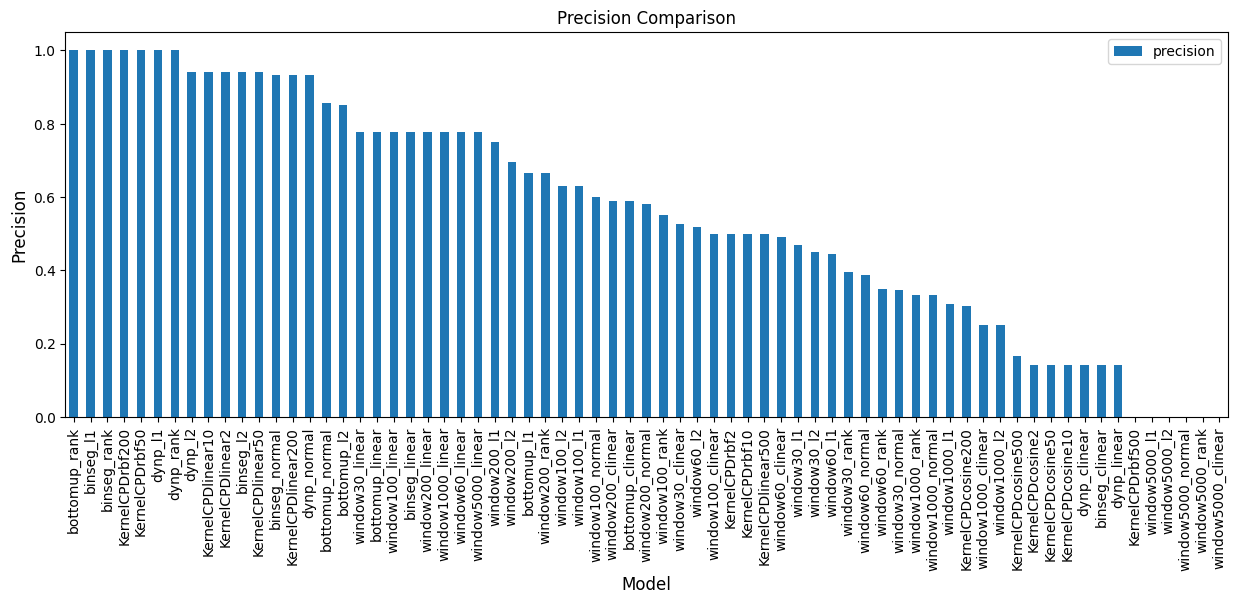

In [13]:
ax = precision_df[['precision']].plot(kind='bar', title ="Precision Comparison", figsize=(15, 5), legend=True, fontsize=10, rot=90)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
plt.show()

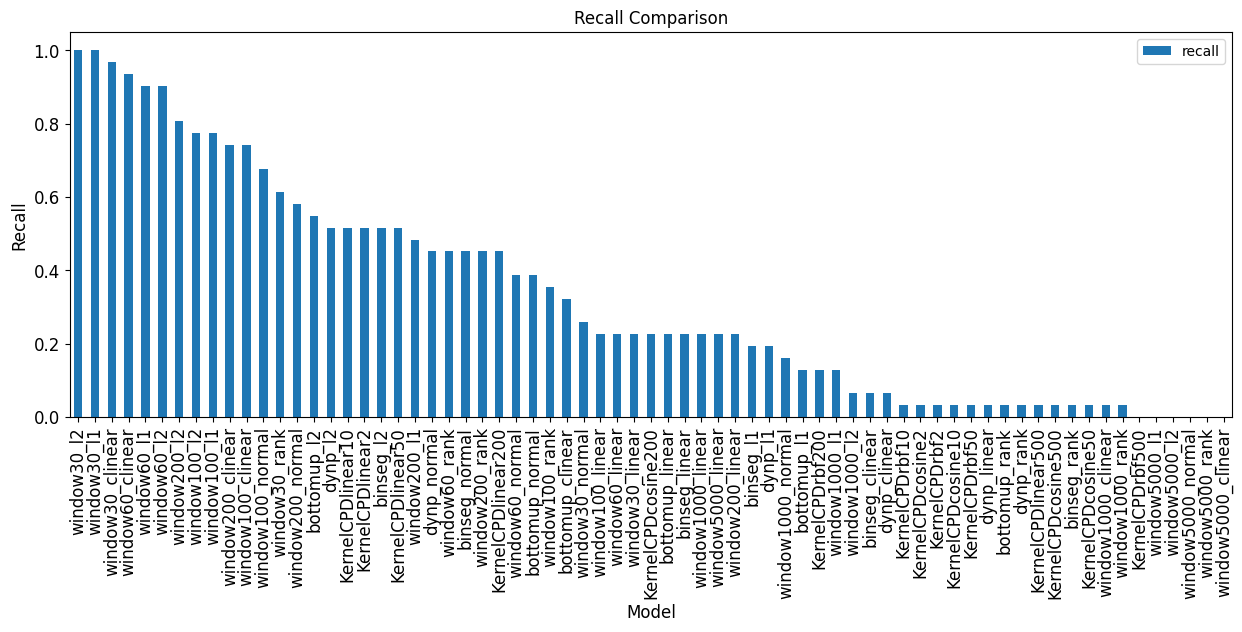

In [14]:
ax = recall_df[['recall']].plot(kind='bar', title ="Recall Comparison", figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
plt.show()

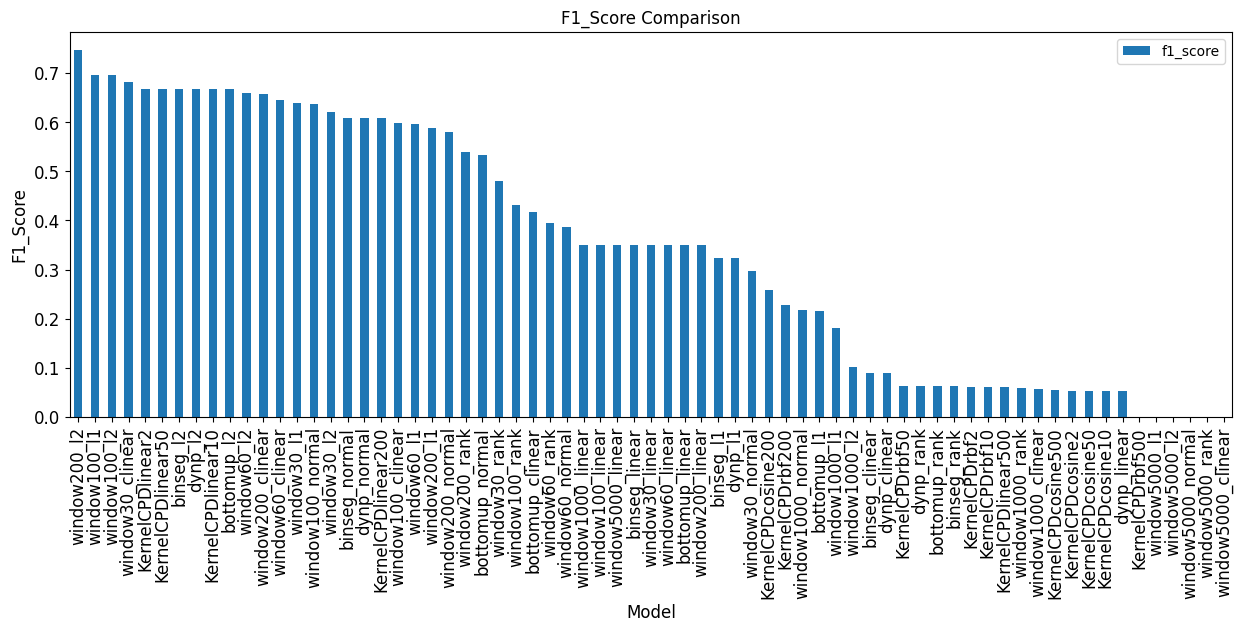

In [15]:
ax = f1_score_df[['f1_score']].plot(kind='bar', title ="F1_Score Comparison", figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("F1_Score", fontsize=12)
plt.show()